# Book-Crossing Recommendation System
> Book recommender system on book crossing dataset using surprise SVD and NMF models

- toc: true
- badges: true
- comments: true
- categories: [Surprise, SVD, NMF, Book]
- author: "<a href='https://github.com/tttgm/fellowshipai'>Tom McKenzie</a>"
- image:

## Setup

In [1]:
!pip install -q git+https://github.com/sparsh-ai/recochef.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 4.3MB 5.4MB/s 


In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn import model_selection

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-white')
plt.rcParams.update({'font.size': 15})
%matplotlib inline

In [3]:
from recochef.datasets.bookcrossing import BookCrossing

## Load the dataset

In [4]:
bookcrossing = BookCrossing()
users = bookcrossing.load_users()
books = bookcrossing.load_items()
book_ratings = bookcrossing.load_interactions()

In [5]:
users.head()

,USERID,LOCATION,AGE
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [6]:
books.head()

,ITEMID,TITLE,AUTHOR,YEAR,PUBLISHER,URLSMALL,URLMEDIUM,URLLARGE
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [7]:
book_ratings.head()

,USERID,ITEMID,RATING
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [8]:
print(f'Users: {len(users)}\nBooks: {len(books)}\nRatings: {len(book_ratings)}')

Users: 278858
Books: 271360
Ratings: 1149780


## EDA and Data cleaning

### Users

In [10]:
users.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
USERID,278858,NaN,NaN,NaN,139430,80499.5,1,69715.2,139430,209144,278858
LOCATION,278858,57339,"london, england, united kingdom",2506,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AGE,168096,NaN,NaN,NaN,34.7514,14.4281,0,24,32,44,244


The age range goes from 0 to 244 years old! Obviously this cannot be correct; I'll set all ages less than 5 and older than 100 to NaN to try keep them realistic.

In [12]:
users.loc[(users.AGE<5) | (users.AGE>100), 'AGE'] = np.nan

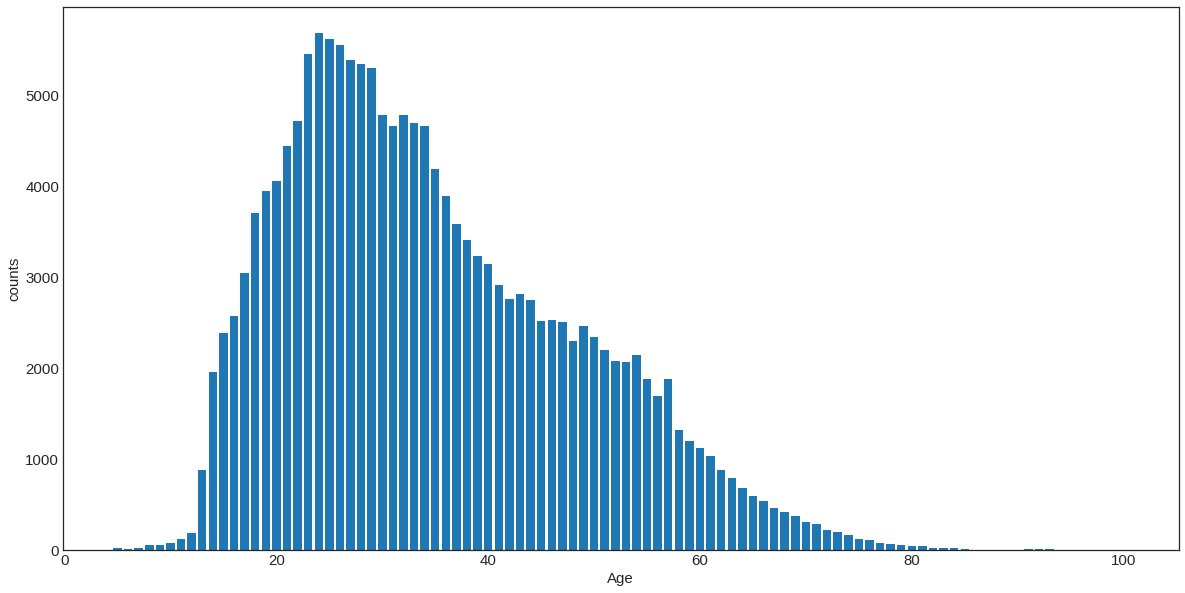

In [16]:
u = users.AGE.value_counts().sort_index()
plt.figure(figsize=(20, 10))
plt.bar(u.index, u.values)
plt.xlabel('Age')
plt.ylabel('counts')
plt.show()

Next, can we expand the 'Location' field to break it up into 'City', 'State', and 'Country'.

> Note: Used Pandas Series.str.split method as it has an 'expand' parameter which can handle None cases

In [18]:
user_location_expanded = users.LOCATION.str.split(',', 2, expand=True)
user_location_expanded.columns = ['CITY', 'STATE', 'COUNTRY']
users = users.join(user_location_expanded)
users.COUNTRY.replace('', np.nan, inplace=True)
users.drop(columns=['LOCATION'], inplace=True)
users.head()

,USERID,AGE,CITY,STATE,COUNTRY
0,1,NaN,nyc,new york,usa
1,2,18.0,stockton,california,usa
2,3,NaN,moscow,yukon territory,russia
3,4,17.0,porto,v.n.gaia,portugal
4,5,NaN,farnborough,hants,united kingdom


### Books

In [20]:
books.head(2)

,ITEMID,TITLE,AUTHOR,YEAR,PUBLISHER,URLSMALL,URLMEDIUM,URLLARGE
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...


In [28]:
books.describe(include='all').T

,count,unique,top,freq
ITEMID,271360,271360,0553141279,1
TITLE,271360,242135,Selected Poems,27
AUTHOR,271359,102023,Agatha Christie,632
YEAR,271360,118,2002,17627
PUBLISHER,271358,16807,Harlequin,7535
URLSMALL,271360,271044,http://images.amazon.com/images/P/051511264X.0...,2
URLMEDIUM,271360,271044,http://images.amazon.com/images/P/038079439X.0...,2
URLLARGE,271357,271041,http://images.amazon.com/images/P/044022859X.0...,2


In [29]:
# Convert years to float
books.YEAR = pd.to_numeric(books.YEAR, errors='coerce')

In [30]:
# Replace all years of zero with NaN
books.YEAR.replace(0, np.nan, inplace=True)

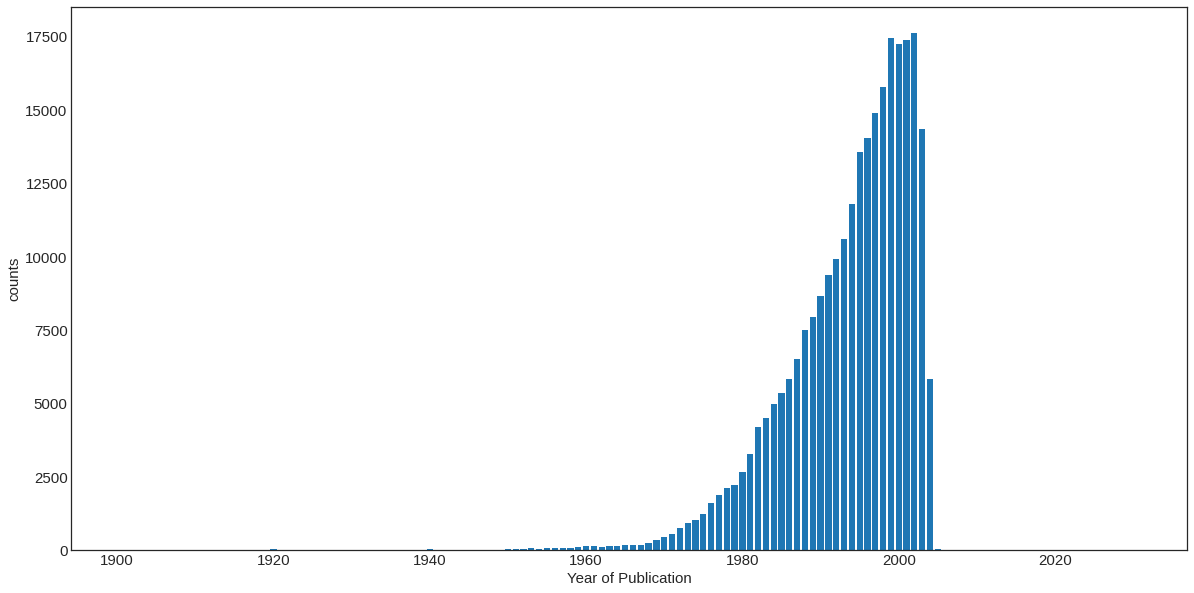

In [24]:
yr = books.YEAR.value_counts().sort_index()
yr = yr.where(yr>5) # filter out counts less than 5
plt.figure(figsize=(20, 10))
plt.bar(yr.index, yr.values)
plt.xlabel('Year of Publication')
plt.ylabel('counts')
plt.show()

Note that in the plot above we filtered out counts less than 5, as there are a few books in the dataset with publication years in the 1300s, and a few in the future (?!). The plot above show the general trend that more recent books are much more frequent.

Let's take a look at some of those 'outlier' books. Maybe we'll even keep them as a separate dataset so we can filter them out if we need to later in the analysis. We'll leave them in for now, and then figure out how to handle them once we have more info later on.

In [31]:
historical_books = books[books.YEAR<1900] # create df of old books
books_from_the_future = books[books.YEAR>2018] # create df of books with publication yrs in the future!

hist_books_mini = historical_books[['TITLE', 'YEAR']]
future_books_mini = books_from_the_future[['TITLE', 'YEAR']]
print(f'Historical books:\n{hist_books_mini}')
print('\n')
print(f'Future books:\n{future_books_mini}')

Historical books:
                                                    TITLE    YEAR
171817  Complete Works 10 Volumes [2,6,7,8,9] (Notable...  1806.0
227531                   Dalan-i bihisht (Dastan-i Irani)  1378.0
245607  Hugh Wynne, Free Quaker (2 Volumes (BCL1-PS Am...  1897.0
253750                                       Tasht-i khun  1376.0


Future books:
                                                    TITLE    YEAR
30010                                          The Royals  2020.0
37487   MY TEACHER FRIED MY BRAINS (RACK SIZE) (MY TEA...  2030.0
55676   MY TEACHER FLUNKED THE PLANET (RACK SIZE) (MY ...  2030.0
78168                                    Crossing America  2030.0
80264   Alice's Adventures in Wonderland and Through t...  2050.0
92156                     Edgar Allen Poe Collected Poems  2020.0
97826       Outline of European Architecture (Pelican S.)  2050.0
116053                       Three Plays of Eugene Oneill  2038.0
118294        Das groÃ?Â?e BÃ?Â¶se- MÃ?Â¤d

I think we can probably omit the 'historical_books' as they may potentially skew the model and do not seem to have much relevance to the wider userbase.

Some of the 'future' books actually appear to be errors (e.g. Alice in Wonderland, Edgar Allen Poe, etc.)... Perhaps they were supposed to be e.g. 1950 instead of 2050? However, instead of investigating this further, since there are <20 books here I will simply remove them from the 'books' table.

In [33]:
print(f'Length of books dataset before removal: {len(books)}')
books = books.loc[~(books.ITEMID.isin(historical_books.ITEMID))] # remove historical books
books = books.loc[~(books.ITEMID.isin(books_from_the_future.ITEMID))] # remove historical books
print(f'Length of books dataset after removal: {len(books)}')

Length of books dataset before removal: 271360
Length of books dataset after removal: 271339


We clean up the ampersand formatting in the Publisher field.

In [34]:
books.PUBLISHER = books.PUBLISHER.str.replace('&amp', '&', regex=False)
books.head()

,ITEMID,TITLE,AUTHOR,YEAR,PUBLISHER,URLSMALL,URLMEDIUM,URLLARGE
0,0195153448,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999.0,W. W. Norton &; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


Check that there are no duplicated book entries.

In [35]:
uniq_books = books.ITEMID.nunique()
all_books = books.ITEMID.count()
print(f'No. of unique books: {uniq_books} | All book entries: {all_books}')

No. of unique books: 271339 | All book entries: 271339


Let's look at the most frequent Publishing houses in the dataset.

In [36]:
top_publishers = books.PUBLISHER.value_counts()[:10]
print(f'The 10 publishers with the most entries in the books table are:\n{top_publishers}')

The 10 publishers with the most entries in the books table are:
Harlequin                   7535
Silhouette                  4220
Pocket                      3905
Ballantine Books            3783
Bantam Books                3646
Scholastic                  3159
Simon &; Schuster           2969
Penguin Books               2844
Berkley Publishing Group    2771
Warner Books                2727
Name: PUBLISHER, dtype: int64


What about authors with the most entries?

In [37]:
top_authors = books.AUTHOR.value_counts()[:10]
print(f'The 10 authors with the most entries in the books table are:\n{top_authors}')

The 10 authors with the most entries in the books table are:
Agatha Christie        632
William Shakespeare    567
Stephen King           524
Ann M. Martin          423
Carolyn Keene          373
Francine Pascal        372
Isaac Asimov           330
Nora Roberts           315
Barbara Cartland       307
Charles Dickens        302
Name: AUTHOR, dtype: int64


We should search for empty or NaN values in these fields too.

In [38]:
empty_string_publisher = books[books.PUBLISHER == ''].PUBLISHER.count()
nan_publisher = books.PUBLISHER.isnull().sum()
print(f'There are {empty_string_publisher} entries with empty strings, and {nan_publisher} NaN entries in the Publisher field')

There are 0 entries with empty strings, and 2 NaN entries in the Publisher field


Great - no empty strings in the Publisher field, and only 2 NaNs.

In [39]:
empty_string_author = books[books.AUTHOR == ''].AUTHOR.count()
nan_author = books.AUTHOR.isnull().sum()
print(f'There are {empty_string_author} entries with empty strings, and {nan_author} NaN entries in the Author field')

There are 0 entries with empty strings, and 1 NaN entries in the Author field


Cool, only 1 NaN in the Author field.

Let's look at the titles.

In [40]:
top_titles = books.TITLE.value_counts()[:10]
print(f'The 10 book titles with the most entries in the books table are:\n{top_titles}')

The 10 book titles with the most entries in the books table are:
Selected Poems                    27
Little Women                      24
Wuthering Heights                 21
The Secret Garden                 20
Adventures of Huckleberry Finn    20
Dracula                           20
Jane Eyre                         19
The Night Before Christmas        18
Pride and Prejudice               18
Great Expectations                17
Name: TITLE, dtype: int64


This is actually quite an important observation. Although all of the ISBN entries are *unique* in the 'books' dataframe, different *forms* of the **same** book will have different ISBNs - i.e. paperback, e-book, etc. Therefore, we can see that some books have multiple ISBN entries (e.g. Jane Eyre has 19 different ISBNs, each corresponding to a different version of the book).

Let's take a look at, for example, the entries for 'Jane Eyre'.

In [41]:
books[books.TITLE=='Jane Eyre']

,ITEMID,TITLE,AUTHOR,YEAR,PUBLISHER,URLSMALL,URLMEDIUM,URLLARGE
3323,0451518845,Jane Eyre,Charlotte Bronte,1999.0,New Amer Library Classics,http://images.amazon.com/images/P/0451518845.0...,http://images.amazon.com/images/P/0451518845.0...,http://images.amazon.com/images/P/0451518845.0...
9545,0451523326,Jane Eyre,Charlotte Bronte,1988.0,Signet Classics,http://images.amazon.com/images/P/0451523326.0...,http://images.amazon.com/images/P/0451523326.0...,http://images.amazon.com/images/P/0451523326.0...
27657,1566193028,Jane Eyre,Charlotte Bronte,1994.0,Dorset Press,http://images.amazon.com/images/P/1566193028.0...,http://images.amazon.com/images/P/1566193028.0...,http://images.amazon.com/images/P/1566193028.0...
28501,156619024X,Jane Eyre,Charlotte Bronte,NaN,Barnes Noble Classics,http://images.amazon.com/images/P/156619024X.0...,http://images.amazon.com/images/P/156619024X.0...,http://images.amazon.com/images/P/156619024X.0...
40050,8426102069,Jane Eyre,Charlotte Bronte,1997.0,Juventud,http://images.amazon.com/images/P/8426102069.0...,http://images.amazon.com/images/P/8426102069.0...,http://images.amazon.com/images/P/8426102069.0...
41265,0553210203,Jane Eyre,Charlotte Bronte,1981.0,Bantam Books,http://images.amazon.com/images/P/0553210203.0...,http://images.amazon.com/images/P/0553210203.0...,http://images.amazon.com/images/P/0553210203.0...
58243,0460012878,Jane Eyre,Charlotte Bronte,1976.0,J m Dent &; Sons Ltd,http://images.amazon.com/images/P/0460012878.0...,http://images.amazon.com/images/P/0460012878.0...,http://images.amazon.com/images/P/0460012878.0...
69689,0141305371,Jane Eyre,Charlotte Bronte,1999.0,Puffin Books,http://images.amazon.com/images/P/0141305371.0...,http://images.amazon.com/images/P/0141305371.0...,http://images.amazon.com/images/P/0141305371.0...
72306,2253004359,Jane Eyre,Charlotte BrontÃ?Â«,1991.0,LGF,http://images.amazon.com/images/P/2253004359.0...,http://images.amazon.com/images/P/2253004359.0...,http://images.amazon.com/images/P/2253004359.0...
84642,0812523377,Jane Eyre,Charlotte Bronte,1994.0,Tor Books,http://images.amazon.com/images/P/0812523377.0...,http://images.amazon.com/images/P/0812523377.0...,http://images.amazon.com/images/P/0812523377.0...


It looks like each ISBN assigned to the book 'Jane Eyre' has different Publisher and Year of Publication values also.

It might be more useful for our model if we simplified this to give each book a *unique* identifier, independent of the book format, as our recommendations will be for a book, not a specific version of a book. Therefore, all values in the Jane Eyre example above would stay the same, except all of the Jane Eyre entries would additionally be assigned a *unique ISBN* code as a new field.

**Will create this more unique identifier under the field name 'UNIQUE_ITEMIDS'. Note that entries with only a single ISBN number will be left the same. However, will need to do this after joining to the other tables in the dataset, as some ISBNs in the 'book-rating' table may be removed if done prior.**

### Interactions

In [43]:
book_ratings.head()

,USERID,ITEMID,RATING
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [44]:
book_ratings.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
USERID,1.14978e+06,NaN,NaN,NaN,140386,80562.3,2,70345,141010,211028,278854
ITEMID,1149780,340556,0971880107,2502,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RATING,1.14978e+06,NaN,NaN,NaN,2.86695,3.85418,0,0,0,7,10


In [45]:
book_ratings.dtypes

USERID     int64
ITEMID    object
RATING     int64
dtype: object

The data types already look good. Remember that the ISBN numbers may contain letters, and so should be left as strings.

Which users contribute the most ratings?

In [46]:
super_users = book_ratings.groupby('USERID').ITEMID.count().sort_values(ascending=False)
print(f'The 20 users with the most ratings:\n{super_users[:20]}')

The 20 users with the most ratings:
USERID
11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
212898     4785
278418     4533
76352      3367
110973     3100
235105     3067
230522     2991
16795      2948
234623     2674
36836      2529
52584      2512
245963     2507
204864     2504
55492      2459
185233     2448
171118     2421
Name: ITEMID, dtype: int64


Wow! User \#11676 has almost twice as many ratings as the next highest user! All of the top 20 users have thousands of ratings, which seems like a lot, although maybe I'm just a slow reader...

Let's see how they are distributed.

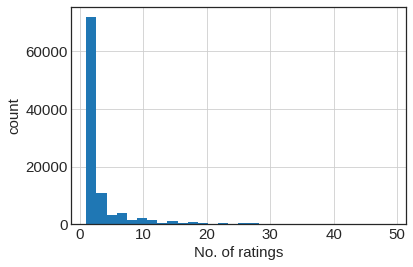

In [47]:
# user distribution - users with more than 50 ratings removed
user_hist = super_users.where(super_users<50)
user_hist.hist(bins=30)
plt.xlabel('No. of ratings')
plt.ylabel('count')
plt.show()

It looks like **_by far_** the most frequent events are users with only 1 or 2 rating entries. We can see that the 'super users' with thousands of ratings are significant outliers.

This becomes clear if we make the same histogram with a cutoff for users with a minimum of 1000 ratings.

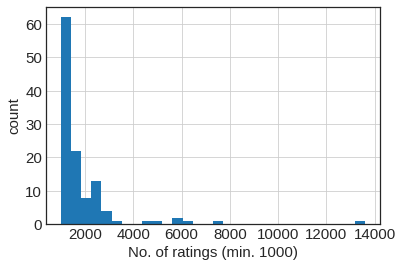

In [48]:
# only users with more than 1000 ratings
super_user_hist = super_users.where(super_users>1000)
super_user_hist.hist(bins=30)
plt.xlabel('No. of ratings (min. 1000)')
plt.ylabel('count')
plt.show()

Let's see what the distribution of **ratings** looks like.

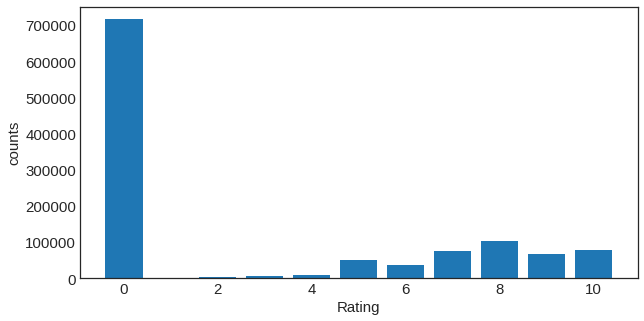

In [49]:
rtg = book_ratings.RATING.value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.bar(rtg.index, rtg.values)
plt.xlabel('Rating')
plt.ylabel('counts')
plt.show()

Seems like most of the entries have a rating of zero!

After doing some research on the internet regarding this (and similar) datasets, it appears that the rating scale is actually from 1 to 10, and a 0 indicates an 'implicit' rather than an 'explicit' rating. An implicit rating represents an interaction (may be positive or negative) between the user and the item. Implicit interactions usually need to be handled differently from explicit ones.

For the modeling step we'll only be looking at *explicit* ratings, and so the 0 rating entry rows will be removed.

In [50]:
print(f'Size of book_ratings before removing zero ratings: {len(book_ratings)}')
book_ratings = book_ratings[book_ratings.RATING != 0]
print(f'Size of book_ratings after removing zero ratings: {len(book_ratings)}')

Size of book_ratings before removing zero ratings: 1149780
Size of book_ratings after removing zero ratings: 433671


By removing the implicit ratings we have reduced our sample size by more than half.

Let's look at how the ratings are distributed again.

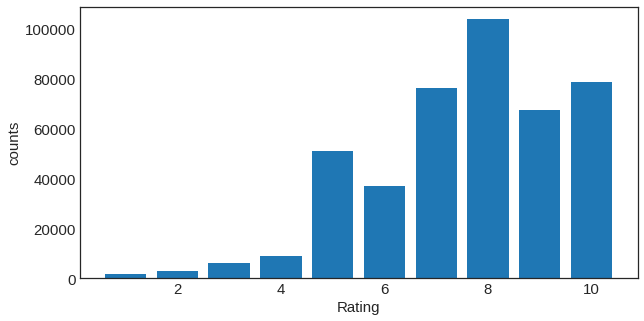

In [51]:
rtg = book_ratings.RATING.value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.bar(rtg.index, rtg.values)
plt.xlabel('Rating')
plt.ylabel('counts')
plt.show()

This is much more clear! Now we can see that 8 is the most frequent rating, while users tend to give ratings > 5, with very few low ratings given.

### Merge

First, we'll join the 'books' table to the 'book_ratings' table on the ISBN field.

In [52]:
print(f'Books table size: {len(books)}')
print(f'Ratings table size: {len(book_ratings)}')
books_with_ratings = book_ratings.join(books.set_index('ITEMID'), on='ITEMID')
print(f'New table size: {len(books_with_ratings)}')

Books table size: 271339
Ratings table size: 433671
New table size: 433671


Let's take a look at the new table.

In [53]:
books_with_ratings.head()

,USERID,ITEMID,RATING,TITLE,AUTHOR,YEAR,PUBLISHER,URLSMALL,URLMEDIUM,URLLARGE
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001.0,Heinle,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999.0,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001.0,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...
6,276736,3257224281,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,276737,0600570967,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
print(f'There are {books_with_ratings.TITLE.isnull().sum()} books with no title/author information.')
print(f'This represents {len(books_with_ratings)/books_with_ratings.TITLE.isnull().sum():.2f}% of the ratings dataset.')

There are 49861 books with no title/author information.
This represents 8.70% of the ratings dataset.


There seems to be quite a few ISBNs in the ratings table that did not match an ISBN in the books table, almost 9% of all entries!

There isn't really anything we can do about that, but we should really remove them from the dataset as we won't be able to access the title of the book to make a recommendation even if the model can use them.

In [55]:
books_with_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 433671 entries, 1 to 1149779
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   USERID     433671 non-null  int64  
 1   ITEMID     433671 non-null  object 
 2   RATING     433671 non-null  int64  
 3   TITLE      383810 non-null  object 
 4   AUTHOR     383809 non-null  object 
 5   YEAR       378026 non-null  float64
 6   PUBLISHER  383808 non-null  object 
 7   URLSMALL   383810 non-null  object 
 8   URLMEDIUM  383810 non-null  object 
 9   URLLARGE   383809 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 36.4+ MB


It looks like the ```year_of_publication``` field contains the most NaN entries, while ```USERID```, ```isbn```, and ```book_rating``` are full. The ```book_title```, ```book_author```, and ```publisher``` fields contain approximately the same number of missing entries.

We'll choose to remove rows for which the ```book_title``` is empty, as this is the most crucial piece of data needed to identify the book.

In [56]:
books_with_ratings.dropna(subset=['TITLE'], inplace=True) # remove rows with missing title/author data

Let's see which books have the highest **cumulative** book rating values.

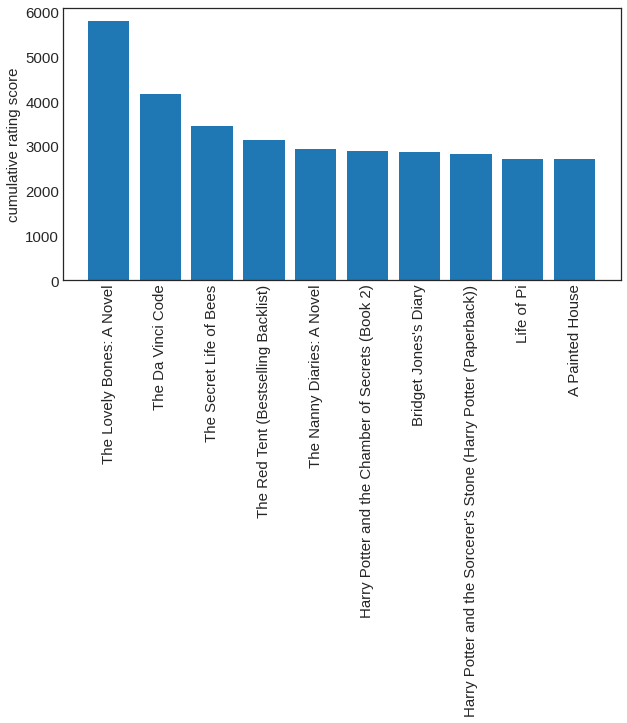

In [57]:
cm_rtg = books_with_ratings.groupby('TITLE').RATING.sum()
cm_rtg = cm_rtg.sort_values(ascending=False)[:10]
idx = cm_rtg.index.tolist() # Get sorted book titles
vals = cm_rtg.values.tolist() # Get corresponding cm_rtg values

plt.figure(figsize=(10, 5))
plt.bar(range(len(idx)), vals)
plt.xticks(range(len(idx)), idx, rotation='vertical')
plt.ylabel('cumulative rating score')
plt.show()

This seems about right as it combines the total number of ratings with the score given, so these are all really popular book titles.

What about the highest **average ratings** (with a minimum of at least 50 ratings recieved)?

In [58]:
cutoff = books_with_ratings.TITLE.value_counts()
mean_rtg = books_with_ratings[books_with_ratings.TITLE.isin(cutoff[cutoff>50].index)].groupby('TITLE')['RATING'].mean()
mean_rtg.sort_values(ascending=False)[:10] # show only top 10

TITLE
The Two Towers (The Lord of the Rings, Part 2)            9.330882
The Return of the King (The Lord of the Rings, Part 3)    9.213592
Harry Potter and the Goblet of Fire (Book 4)              9.125506
The Little Prince                                         9.111111
Charlotte's Web (Trophy Newbery)                          9.073529
Harry Potter and the Sorcerer's Stone (Book 1)            9.062500
84 Charing Cross Road                                     9.049180
Harry Potter and the Order of the Phoenix (Book 5)        9.047393
Harry Potter and the Prisoner of Azkaban (Book 3)         9.043321
To Kill a Mockingbird                                     8.977528
Name: RATING, dtype: float64

This looks perfectly reasonable. The Harry Potter and Lord of the Rings books rate extremely highly, as expected.

How about the **lowest-rated** books?

In [59]:
mean_rtg.sort_values(ascending=False)[-10:] # bottom 10 only

TITLE
Slow Waltz in Cedar Bend                                  6.619718
My Gal Sunday                                             6.607843
Hornet's Nest                                             6.591398
Bleachers                                                 6.583333
Full Tilt (Janet Evanovich's Full Series)                 6.568627
Songs in Ordinary Time (Oprah's Book Club (Paperback))    6.530303
4 Blondes                                                 5.653846
Isle of Dogs                                              5.433962
Four Blondes                                              5.393939
Wild Animus                                               4.390706
Name: RATING, dtype: float64

Seems like the *lowest average* rating in the dataset is only a 4.39 - and all the rest of the books have average ratings higher than 5.

I haven't heard of any of these books, so I can't really comment on if they seem correct here.

**Now I'd like to tackle the challenge of the same book potentially having multiple ISBN numbers (for the different formats it is available in). We should clean that up here before we add the 'user' table.**

### Single ISBN per book
Restrict books to a "single ISBN per book" (regardless of format)

Let's look again at the book titles which have the most associated ISBN numbers.

In [60]:
books_with_ratings.groupby('TITLE').ITEMID.nunique().sort_values(ascending=False)[:10]

TITLE
The Secret Garden                 18
Selected Poems                    16
Adventures of Huckleberry Finn    15
Dracula                           15
Beloved                           14
Wuthering Heights                 14
Jane Eyre                         14
Pride and Prejudice               14
Little Women                      14
The Hobbit                        12
Name: ITEMID, dtype: int64

In [61]:
multiple_isbns = books_with_ratings.groupby('TITLE').ITEMID.nunique()
multiple_isbns.value_counts()

1     125322
2       7872
3       1497
4        493
5        181
6         86
7         44
8         27
9         11
10         8
14         5
15         2
11         2
18         1
16         1
12         1
Name: ITEMID, dtype: int64

We can see that the vast majority of books have less only 1 associated ISBN number, however quite a few multiple ISBNs. We want to create a ```UNIQUE_ITEMIDS``` such that a single book will only have 1 identifier when fed to the recommendation model.

In [62]:
has_mult_isbns = multiple_isbns.where(multiple_isbns>1)
has_mult_isbns.dropna(inplace=True) # remove NaNs, which in this case is books with a single ISBN number

In [63]:
print(f'There are {len(has_mult_isbns)} book titles with multiple ISBN numbers which we will try to re-assign to a unique identifier')

There are 10231 book titles with multiple ISBN numbers which we will try to re-assign to a unique identifier


In [64]:
# Check to see that our friend Jane Eyre still has multiple ISBN values
has_mult_isbns['Jane Eyre']

14.0

**Note:** Created the dictionary below and pickled it, just need to load it again (or run it if the first time on a new system).

In [66]:
# Create dictionary for books with multiple isbns
def make_isbn_dict(df):
    title_isbn_dict = {}
    for title in has_mult_isbns.index:
        isbn_series = df.loc[df.TITLE==title].ITEMID.unique() # returns only the unique ISBNs
        title_isbn_dict[title] = isbn_series.tolist()
    return title_isbn_dict

%time dict_UNIQUE_ITEMIDS = make_isbn_dict(books_with_ratings)

# As the loop takes a while to run (8 min on the full dataset), pickle this dict for future use
with open('multiple_isbn_dict.pickle', 'wb') as handle:
    pickle.dump(dict_UNIQUE_ITEMIDS, handle, protocol=pickle.HIGHEST_PROTOCOL)

# LOAD isbn_dict back into namespace
with open('multiple_isbn_dict.pickle', 'rb') as handle:
    multiple_isbn_dict = pickle.load(handle)

CPU times: user 8min 32s, sys: 1.61 s, total: 8min 34s
Wall time: 8min 33s


In [67]:
print(f'There are now {len(multiple_isbn_dict)} books in the ISBN dictionary that have multiple ISBN numbers')

There are now 10231 books in the ISBN dictionary that have multiple ISBN numbers


Let's take a quick look in the dict we just created for the 'Jane Eyre' entry - it should contain a list of 14 ISBN numbers.

In [68]:
print(f'Length of Jane Eyre dict entry: {len(multiple_isbn_dict["Jane Eyre"])}\n')
multiple_isbn_dict['Jane Eyre']

Length of Jane Eyre dict entry: 14



['1590071212',
 '0451518845',
 '0451523326',
 '843761449X',
 '156619024X',
 '8426102069',
 '1566193028',
 '0141305371',
 '3548301231',
 '0812523377',
 '0517668432',
 '2253004359',
 '0553210203',
 '0451515560']

Looking good!

As I don't really know what each of the different ISBN numbers refers to (from what I understand the code actually signifies various things including publisher, year, type of print, etc, but decoding this is outside the scope of this analysis), I'll just select the **first** ISBN number that appears in the list of values to set as our ```UNIQUE_ITEMIDS``` for that particular book.

_**Note**_: ISBN numbers are currently 13 digits long, but used to be 10. Any ISBN that isn't 10 or 13 digits long is probably an error that should be handled somehow. Any that are 9 digits long might actually be SBN numbers (pre-1970), and can be converted into ISBN's by just pre-fixing with a zero.

In [74]:
# Add 'UNIQUE_ITEMIDS' column to 'books_with_ratings' dataframe that includes the first ISBN if multiple ISBNS,
# or just the ISBN if only 1 ISBN present anyway.
def add_UNIQUE_ITEMIDS_col(df):
    df['UNIQUE_ITEMIDS'] = df.apply(lambda row: multiple_isbn_dict[row.TITLE][0] if row.TITLE in multiple_isbn_dict.keys() else row.ITEMID, axis=1)
    return df

%time books_with_ratings = add_UNIQUE_ITEMIDS_col(books_with_ratings)

CPU times: user 7.77 s, sys: 53.9 ms, total: 7.82 s
Wall time: 7.82 s


In [75]:
books_with_ratings.head()

,USERID,ITEMID,RATING,TITLE,AUTHOR,YEAR,PUBLISHER,URLSMALL,URLMEDIUM,URLLARGE,UNIQUE_ITEMIDS
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001.0,Heinle,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...,0155061224
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999.0,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...,052165615X
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001.0,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...,0521795028
8,276744,038550120X,7,A Painted House,JOHN GRISHAM,2001.0,Doubleday,http://images.amazon.com/images/P/038550120X.0...,http://images.amazon.com/images/P/038550120X.0...,http://images.amazon.com/images/P/038550120X.0...,038550120X
16,276747,0060517794,9,Little Altars Everywhere,Rebecca Wells,2003.0,HarperTorch,http://images.amazon.com/images/P/0060517794.0...,http://images.amazon.com/images/P/0060517794.0...,http://images.amazon.com/images/P/0060517794.0...,0060517794


The table now includes our ```UNIQUE_ITEMIDS``` field.

Let's check to see if the 'Jane Eyre' entries have been assigned the ISBN '1590071212', which was the first val in the dictionary for this title.

In [76]:
books_with_ratings[books_with_ratings.TITLE=='Jane Eyre'].head()

,USERID,ITEMID,RATING,TITLE,AUTHOR,YEAR,PUBLISHER,URLSMALL,URLMEDIUM,URLLARGE,UNIQUE_ITEMIDS
10481,387,1590071212,9,Jane Eyre,Charlotte Bronte,2002.0,New Millenium Audio,http://images.amazon.com/images/P/1590071212.0...,http://images.amazon.com/images/P/1590071212.0...,http://images.amazon.com/images/P/1590071212.0...,1590071212
16178,2718,0451518845,10,Jane Eyre,Charlotte Bronte,1999.0,New Amer Library Classics,http://images.amazon.com/images/P/0451518845.0...,http://images.amazon.com/images/P/0451518845.0...,http://images.amazon.com/images/P/0451518845.0...,1590071212
35499,8370,0451523326,8,Jane Eyre,Charlotte Bronte,1988.0,Signet Classics,http://images.amazon.com/images/P/0451523326.0...,http://images.amazon.com/images/P/0451523326.0...,http://images.amazon.com/images/P/0451523326.0...,1590071212
50842,11676,0451523326,9,Jane Eyre,Charlotte Bronte,1988.0,Signet Classics,http://images.amazon.com/images/P/0451523326.0...,http://images.amazon.com/images/P/0451523326.0...,http://images.amazon.com/images/P/0451523326.0...,1590071212
58066,11676,843761449X,8,Jane Eyre,Charlotte Bronte,1998.0,Ediciones Catedra S.A.,http://images.amazon.com/images/P/843761449X.0...,http://images.amazon.com/images/P/843761449X.0...,http://images.amazon.com/images/P/843761449X.0...,1590071212


Great! Seems to have worked well.

We won't replace the original ISBN column with the 'UNIQUE_ITEMIDS' column, but just note that the recommendation model should be based on the 'UNIQUE_ITEMIDS' field.

### Remove Small and Large book-cover URL columns

In [79]:
books_users_ratings.drop(['URLSMALL', 'URLLARGE'], axis=1, inplace=True)

## Join the 'users' table on the 'USERID' field

In [77]:
print(f'Books+Ratings table size: {len(books_with_ratings)}')
print(f'Users table size: {len(users)}')
books_users_ratings = books_with_ratings.join(users.set_index('USERID'), on='USERID')
print(f'New "books_users_ratings" table size: {len(books_users_ratings)}')

Books+Ratings table size: 383810
Users table size: 278858
New "books_users_ratings" table size: 383810


Inspect the new table.

In [80]:
books_users_ratings.head()

,USERID,ITEMID,RATING,TITLE,AUTHOR,YEAR,PUBLISHER,URLMEDIUM,UNIQUE_ITEMIDS,AGE,CITY,STATE,COUNTRY
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001.0,Heinle,http://images.amazon.com/images/P/0155061224.0...,0155061224,NaN,seattle,washington,usa
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999.0,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...,052165615X,16.0,rijeka,n/a,croatia
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001.0,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...,0521795028,16.0,rijeka,n/a,croatia
8,276744,038550120X,7,A Painted House,JOHN GRISHAM,2001.0,Doubleday,http://images.amazon.com/images/P/038550120X.0...,038550120X,NaN,torrance,california,usa
16,276747,0060517794,9,Little Altars Everywhere,Rebecca Wells,2003.0,HarperTorch,http://images.amazon.com/images/P/0060517794.0...,0060517794,25.0,iowa city,iowa,usa


In [81]:
books_users_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383810 entries, 1 to 1149778
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   USERID          383810 non-null  int64  
 1   ITEMID          383810 non-null  object 
 2   RATING          383810 non-null  int64  
 3   TITLE           383810 non-null  object 
 4   AUTHOR          383809 non-null  object 
 5   YEAR            378026 non-null  float64
 6   PUBLISHER       383808 non-null  object 
 7   URLMEDIUM       383810 non-null  object 
 8   UNIQUE_ITEMIDS  383810 non-null  object 
 9   AGE             267996 non-null  float64
 10  CITY            383810 non-null  object 
 11  STATE           383810 non-null  object 
 12  COUNTRY         373330 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 41.0+ MB


There are a few missing ```age```, ```year_of_publication```, ```publisher```, and ```country``` entries, but the primary fields of ```USERID```, ```UNIQUE_ITEMIDS```, and ```book_rating``` are all full, which is good.

In terms of the data types, ```USERID``` and ```book_rating``` are integers, while the ```UNIQUE_ITEMIDS``` are strings (which is expected as the ISBN numbers may also contain letters).

In [82]:
books_users_ratings.shape

(383810, 13)

## Recommender model

Collaborative filtering use similarities of the 'user' and 'item' fields, with values of 'rating' predicted based on either user-item, or item-item similarity:
 - Item-Item CF: "Users who liked this item also liked..."
 - User-Item CF: "Users who are similar to you also liked..."
 
In both cases, we need to create a user-item matrix built from the entire dataset. We'll create a matrix for each of the training and testing sets, with the users as the rows, the books as the columns, and the rating as the matrix value. Note that this will be a very sparse matrix, as not every user will have watched every movie etc.

We'll first create a new dataframe that contains only the relevant columns (```USERID```, ```UNIQUE_ITEMIDS```, and ```book_rating```).

In [83]:
user_item_rating = books_users_ratings[['USERID', 'UNIQUE_ITEMIDS', 'RATING']]
user_item_rating.head()

,USERID,UNIQUE_ITEMIDS,RATING
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
8,276744,038550120X,7
16,276747,0060517794,9


We know what the distribution of ratings should look like (as we plotted it earlier) - let's plot it again on this new dataframe to just quickly check that it looks right.

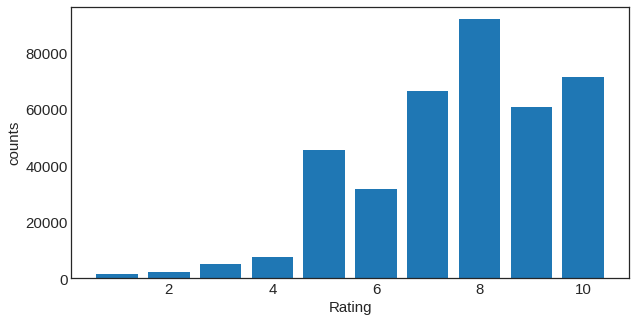

In [84]:
rtg = user_item_rating.RATING.value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.bar(rtg.index, rtg.values)
plt.xlabel('Rating')
plt.ylabel('counts')
plt.show()

Looks perfect! Continue.

### Using ```sklearn``` to generate training and testing subsets

In [86]:
train_data, test_data = model_selection.train_test_split(user_item_rating, test_size=0.20)

In [87]:
print(f'Training set size: {len(train_data)}')
print(f'Testing set size: {len(test_data)}')
print(f'Test set is {(len(test_data)/(len(train_data)+len(test_data))*100):.0f}% of the full dataset.')

Training set size: 307048
Testing set size: 76762
Test set is 20% of the full dataset.


### Map the ```USERID``` and ```UNIQUE_ITEMIDS``` fields to sequential integers for matrix processing

In [88]:
### TRAINING SET
# Get int mapping for USERID
u_unique_train = train_data.USERID.unique()  # create a 'set' (i.e. all unique) list of vals
train_data_user2idx = {o:i for i, o in enumerate(u_unique_train)}
# Get int mapping for UNIQUE_ITEMIDS
b_unique_train = train_data.UNIQUE_ITEMIDS.unique()  # create a 'set' (i.e. all unique) list of vals
train_data_book2idx = {o:i for i, o in enumerate(b_unique_train)}

### TESTING SET
# Get int mapping for USERID
u_unique_test = test_data.USERID.unique()  # create a 'set' (i.e. all unique) list of vals
test_data_user2idx = {o:i for i, o in enumerate(u_unique_test)}
# Get int mapping for UNIQUE_ITEMIDS
b_unique_test = test_data.UNIQUE_ITEMIDS.unique()  # create a 'set' (i.e. all unique) list of vals
test_data_book2idx = {o:i for i, o in enumerate(b_unique_test)}

In [89]:
### TRAINING SET
train_data['USER_UNIQUE'] = train_data['USERID'].map(train_data_user2idx)
train_data['ITEM_UNIQUE'] = train_data['UNIQUE_ITEMIDS'].map(train_data_book2idx)

### TESTING SET
test_data['USER_UNIQUE'] = test_data['USERID'].map(test_data_user2idx)
test_data['ITEM_UNIQUE'] = test_data['UNIQUE_ITEMIDS'].map(test_data_book2idx)

### Convert back to 3-column df
train_data = train_data[['USER_UNIQUE', 'ITEM_UNIQUE', 'RATING']]
test_data = test_data[['USER_UNIQUE', 'ITEM_UNIQUE', 'RATING']]

In [90]:
train_data.tail()

,USER_UNIQUE,ITEM_UNIQUE,RATING
436369,3013,41654,10
1022064,59278,116980,8
524738,6887,21241,5
340428,2495,15166,8
443166,11135,10688,10


In [91]:
train_data.dtypes

USER_UNIQUE    int64
ITEM_UNIQUE    int64
RATING         int64
dtype: object

This dataset is now ready to be processed via a collaborative filtering approach!

**Note:** When we need to identify the user or book from the model we'll need to refer back to the ```train_data_user2idx``` and ```train_data_book2idx``` dictionaries to locate the ```USERID``` and ```UNIQUE_ITEMIDS```, respectively.

In [ ]:
### TRAINING SET
# Create user-item matrices
n_users = train_data['USER_UNIQUE'].nunique()
n_books = train_data['ITEM_UNIQUE'].nunique()

# First, create an empty matrix of size USERS x BOOKS (this speeds up the later steps)
train_matrix = np.zeros((n_users, n_books))

# Then, add the appropriate vals to the matrix by extracting them from the df with itertuples
for entry in train_data.itertuples(): # entry[1] is the user-id, entry[2] is the book-isbn
    train_matrix[entry[1]-1, entry[2]-1] = entry[3] # -1 is to counter 0-based indexing

In [ ]:
train_matrix.shape

(59851, 117107)

Now do the same for the test set.

In [ ]:
### TESTING SET
# Create user-item matrices
n_users = test_data['u_unique'].nunique()
n_books = test_data['b_unique'].nunique()

# First, create an empty matrix of size USERS x BOOKS (this speeds up the later steps)
test_matrix = np.zeros((n_users, n_books))

# Then, add the appropriate vals to the matrix by extracting them from the df with itertuples
for entry in test_data.itertuples(): # entry[1] is the user-id, entry[2] is the book-isbn
    test_matrix[entry[1]-1, entry[2]-1] = entry[3] # -1 is to counter 0-based indexing

In [ ]:
test_matrix.shape

(26007, 43403)

Now the matrix is in the correct format, with the user and book entries encoded from the mapping dict created above!

### Calculating cosine similarity with the 'pairwise distances' function

To determine the similarity between users/items we'll use the 'cosine similarity' which is a common n-dimensional distance metric.

**Note:** since all of the rating values are positive (1-10 scale), the cosine distances will all fall between 0 and 1.

In [ ]:
# It may take a while to calculate, so I'll perform on a subset initially
train_matrix_small = train_matrix[:10000, :10000]
test_matrix_small = test_matrix[:10000, :10000]

from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(train_matrix_small, metric='cosine')
item_similarity = pairwise_distances(train_matrix_small.T, metric='cosine') # .T transposes the matrix (NumPy)

If we are looking at similarity between users we need to account for the average behaviour of that individual user. For example, one user may give all movies quite high ratings, whereas one might give all ratings between 3 and 7. These users might otherwise have quite similar preferences.

To do this, we use the users average rating as a 'weighting' factor.

If we are looking at item-based similarity we don't need to add this weighting factor.

We can incorporate this into a ```predict()``` function, like so:

In [ ]:
def predict(ratings, similarity, type='user'): # default type is 'user'
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        # Use np.newaxis so that mean_user_rating has the same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

Then can make our predictions!

In [ ]:
item_prediction = predict(train_matrix_small, item_similarity, type='item')
user_prediction = predict(train_matrix_small, user_similarity, type='user')

### Evaluation

How do we know if this is making good ```rating``` predictions?

We'll start by just taking the root mean squared error (RMSE) (from ```sklearn```) of predicted values in the ```test_set``` (i.e. where we know what the answer should be).

Since we want to compare only predicted ratings that are in the test set, we can filter out all other predictions that aren't in the test matrix.

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(prediction, test_matrix):
    prediction = prediction[test_matrix.nonzero()].flatten()
    test_matrix = test_matrix[test_matrix.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, test_matrix))

# Call on test set to get error from each approach ('user' or 'item')
print(f'User-based CF RMSE: {rmse(user_prediction, test_matrix_small)}')
print(f'Item-based CF RMSE: {rmse(item_prediction, test_matrix_small)}')

User-based CF RMSE: 7.929926397008533
Item-based CF RMSE: 7.930326958653732


For the user-item and the item-item recommendations we get RMSE = 7.85 (MSE > 60) for both. This is pretty bad, but we only trained over a small subset of the data.

Although this collaborative filtering setup is relatively simple to write, it doesn't scale very well at all, as it is all stored in memory! (Hence why we only used a subset of the training/testing data).

----------------

Instead, we should really use a model-based (based on matrix factorization) recommendation algorithm. These are inherently more scalable and can deal with higher sparsity level than memory-based models, and are considered more powerful due to their ability to pick up on "latent factors" in the relationships between what sets of items users like. However, they still suffer from the "cold start" problem (where a new user has no history).

Fortunately, there is a Python library called ```surprise``` that was built specifically for the implementation of model-based recommendation systems! This library comes with many of the leading algorithms in this space already built-in. Let's try use it for our book recommender system.

# Using the ```surprise``` library for building a recommender system
Several common model-based algorithms including SVD, KNN, and non-negative matrix factorization are built-in!  
See [here](http://surprise.readthedocs.io/en/stable/getting_started.html#basic-usage) for the docs.

In [ ]:
from surprise import Reader, Dataset

In [ ]:
user_item_rating.head() # take a look at our data

,user_id,unique_isbn,book_rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
8,276744,038550120X,7
16,276747,0060517794,9


In [ ]:
# First need to create a 'Reader' object to set the scale/limit of the ratings field
reader = Reader(rating_scale=(1, 10))

# Load the data into a 'Dataset' object directly from the pandas df.
# Note: The fields must be in the order: user, item, rating
data = Dataset.load_from_df(user_item_rating, reader)

In [ ]:
# Load the models and 'evaluation' method
from surprise import SVD, NMF, model_selection, accuracy

Where: SVD = Singular Value Decomposition (orthogonal factorization), NMF = Non-negative Matrix Factorization.

**Note** that when using the ```surprise``` library we don't need to manually create the mapping of USERID and UNIQUE_ITEMIDS to integers in a custom dict. See [here](http://surprise.readthedocs.io/en/stable/FAQ.html#raw-inner-note) for details. 

### SVD model

**_Using cross-validation (5 folds)_**

In [ ]:
# Load SVD algorithm
model = SVD()

# Train on books dataset
%time model_selection.cross_validate(model, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.6379  1.6342  1.6399  1.6333  1.6383  1.6367  0.0025  
Fit time          27.50   29.12   28.19   28.50   27.17   28.09   0.70    
Test time         1.26    1.28    1.25    1.07    1.22    1.22    0.07    
CPU times: user 2min 32s, sys: 1.44 s, total: 2min 33s
Wall time: 2min 34s


{'fit_time': (27.502967834472656,
  29.117522954940796,
  28.18734574317932,
  28.497459888458252,
  27.168857097625732),
 'test_rmse': array([1.63792973, 1.63415582, 1.63987213, 1.63326894, 1.63828638]),
 'test_time': (1.2554690837860107,
  1.2811057567596436,
  1.2533769607543945,
  1.0734889507293701,
  1.2155327796936035)}

The SVD model gives an average RMSE of ca. 1.64 after 5-folds, with a fit time of ca. 28 s for each fold.

**_Using test-train split_**

In [ ]:
# set test set to 20%.
trainset, testset = model_selection.train_test_split(data, test_size=0.2)

# Instantiate the SVD model.
model = SVD()

# Train the algorithm on the training set, and predict ratings for the test set
model.fit(trainset)
predictions = model.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 1.6355


1.635463484151215

Using a 80% train-test split, the SVD model gave a RMSE of 1.6426.

-----------

We can see that using the SVD algorithm has already far out-performed the memory-based collaborative filtering approach (RMSE of 1.64 vs 7.92)!

### NMF model

In [ ]:
# Load NMF algorithm
model = NMF()
# Train on books dataset
%time model_selection.cross_validate(model, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.4719  2.4753  2.4991  2.4583  2.4690  2.4747  0.0134  
Fit time          48.55   48.36   48.67   48.21   49.12   48.58   0.31    
Test time         1.00    1.22    1.24    0.89    1.27    1.12    0.15    
CPU times: user 4min 12s, sys: 2.77 s, total: 4min 15s
Wall time: 4min 15s


{'fit_time': (48.549073934555054,
  48.363773822784424,
  48.67202186584473,
  48.2091269493103,
  49.12370300292969),
 'test_rmse': array([2.47190526, 2.47525086, 2.49908596, 2.45830639, 2.46903139]),
 'test_time': (0.9956762790679932,
  1.2233927249908447,
  1.2397921085357666,
  0.8911020755767822,
  1.2676730155944824)}

The NMF model gave a mean RMSE of ca. 2.47, with a fit time of ca. 48 s.

It seems like the SVD algorithm is the best choice for this dataset.

## Optimizing the SVD algorithm with parameter tuning
Since it seems like the SVD algorithm is our best choice, let's see if we can improve the predictions even further by optimizing some of the algorithm hyperparameters.

One way of doing this is to use the handy ```GridSearchCV``` method from the ```surprise``` library. When passed a range of hyperparameter values, ```GridSearchCV``` will automatically search through the parameter-space to find the best-performing set of hyperparameters.

In [ ]:
# We'll remake the training set, keeping 20% for testing
trainset, testset = model_selection.train_test_split(data, test_size=0.2)

In [ ]:
### Fine-tune Surprise SVD model useing GridSearchCV
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [80, 100, 120], 'lr_all': [0.001, 0.005, 0.01], 'reg_all': [0.01, 0.02, 0.04]}

# Optimize SVD algorithm for both root mean squared error ('rmse') and mean average error ('mae')
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

In [ ]:
# Fit the gridsearch result on the entire dataset
%time gs.fit(data)

CPU times: user 34min 9s, sys: 10.8 s, total: 34min 20s
Wall time: 34min 29s


In [ ]:
# Return the best version of the SVD algorithm
model = gs.best_estimator['rmse']

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

1.6376613092691847
{'n_factors': 80, 'lr_all': 0.005, 'reg_all': 0.04}


In [ ]:
model_selection.cross_validate(model, data, measures=['rmse', 'mae'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.6326  1.6292  1.6314  1.6323  1.6296  1.6310  0.0014  
MAE (testset)     1.2594  1.2612  1.2611  1.2587  1.2563  1.2593  0.0018  
Fit time          25.22   24.25   24.24   24.00   24.18   24.38   0.43    
Test time         1.08    1.46    1.46    1.05    1.04    1.22    0.20    


{'fit_time': (25.217539072036743,
  24.249317169189453,
  24.235455989837646,
  24.002593994140625,
  24.184158086776733),
 'test_mae': array([1.25944594, 1.26118138, 1.2610566 , 1.25867174, 1.25627505]),
 'test_rmse': array([1.63260117, 1.6291625 , 1.63136824, 1.63232568, 1.62957994]),
 'test_time': (1.0834269523620605,
  1.4560067653656006,
  1.464034080505371,
  1.0514049530029297,
  1.0434091091156006)}

The mean RSME using the optimized parameters was 1.6351 over 5 folds, with an average fit time of ca. 24s.

In [ ]:
### Use the new parameters with the training set
model = SVD(n_factors=80, lr_all=0.005, reg_all=0.04)
model.fit(trainset) # re-fit on only the training data using the best hyperparameters
test_pred = model.test(testset)
print("SVD : Test Set")
accuracy.rmse(test_pred, verbose=True)

SVD : Test Set
RMSE: 1.6287


1.6287348933888393

Using the optimized hyperparameters we see a slight improvement in the resulting RMSE (1.629) compared with the unoptimized SVD algorithm (1.635)1

## Testing some of the outputs (ratings and recommendations)
Would like to do an intuitive check of some of the recommendations being made.

Let's just choose a random user/book pair (represented in the ```suprise``` library as ```uid``` and ```iid```, respectively).

**Note:** The ```model``` being used here is the optimized SVD algorithm that has been fit on the training set.

In [ ]:
# get a prediction for specific users and items.
uid = 276744  # the USERID int
iid = '038550120X' # the UNIQUE_ITEMIDS string
# This pair has an actual rating of 7!

pred = model.predict(uid, iid, verbose=True)

user: 276744     item: 038550120X r_ui = None   est = 7.18   {'was_impossible': False}


Can access the attributes of the ```predict``` method to get a nicer output.

In [ ]:
print(f'The estimated rating for the book with the "UNIQUE_ITEMIDS" code {pred.iid} from user #{pred.uid} is {pred.est:.2f}.\n')
actual_rtg = user_item_rating[(user_item_rating.USERID==pred.uid) & (user_item_rating.UNIQUE_ITEMIDS==pred.iid)].RATING.values[0]
print(f'The real rating given for this was {actual_rtg:.2f}.')

The estimated rating for the book with the "unique_isbn" code 038550120X from user #276744 is 7.18.

The real rating given for this was 7.00.


In [ ]:
# get a prediction for specific users and items.
uid = 95095  # the USERID int
iid = '0140079963' # the UNIQUE_ITEMIDS string
# This pair has an actual rating of 6.0!

pred = model.predict(uid, iid, verbose=True)

user: 95095      item: 0140079963 r_ui = None   est = 6.87   {'was_impossible': False}


In [ ]:
print(f'The estimated rating for the book with the "UNIQUE_ITEMIDS" code {pred.iid} from user #{pred.uid} is {pred.est:.2f}.\n')
actual_rtg = user_item_rating[(user_item_rating.USERID==pred.uid) & (user_item_rating.UNIQUE_ITEMIDS==pred.iid)].RATING.values[0]
print(f'The real rating given for this was {actual_rtg:.2f}.')

The estimated rating for the book with the "unique_isbn" code 0140079963 from user #95095 is 6.87.

The real rating given for this was 6.00.


The following function was adapted from the ```surprise``` docs, and can be used to get the top book recommendations for each user.

In [ ]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
        
    return top_n

Let's get the Top 10 recommended books for each USERID in the test set.

In [ ]:
pred = model.test(testset)
top_n = get_top_n(pred)

In [ ]:
def get_reading_list(userid):
    """
    Retrieve full book titles from full 'books_users_ratings' dataframe
    """
    reading_list = defaultdict(list)
    top_n = get_top_n(predictions, n=10)
    for n in top_n[userid]:
        book, rating = n
        title = books_users_ratings.loc[books_users_ratings.UNIQUE_ITEMIDS==book].TITLE.unique()[0]
        reading_list[title] = rating
    return reading_list

In [ ]:
# Just take a random look at USERID=60337
example_reading_list = get_reading_list(userid=60337)
for book, rating in example_reading_list.items():
    print(f'{book}: {rating}')

A Natural History of the Senses: 9.124985146110324
Grace For The Moment: 9.004232452533614
Eva Luna: 8.957717816714606
A Slender Thread : Rediscovering Hope at the Heart of Crisis: 8.81756023683983
Tell Me the Truth About Love: Ten Poems: 8.729204207356146
Papa, My Father: A Celebration of Dads: 8.708985984501158
Let the Dead Bury Their Dead (Harvest American Writing Series): 8.646273705729296
The Doctor's Book of Home Remedies : Thousands of Tips and Techniques Anyone Can Use to Heal Everyday Health Problems: 8.635645117795315
Why We Cant Wait: 8.535174763005822
Lump It or Leave It: 8.535174763005822


Have tried out a few different ```userid``` entries (from the ```testset```) to see what the top 10 books that user would like are and they seem pretty well related, indicating that the recommendation engine is performing reasonably well!

# Summary

In this notebook a dataset from the 'Book-Crossing' website was used to create a recommendation system. A few different approaches were investigated, including memory-based correlations, and model-based matrix factorization algorithms[2]. Of these, the latter - and particularly the Singular Value Decomposition (SVD) algorithm - gave the best performance as assessed by comparing the predicted book ratings for a given user with the actual rating in a test set that the model was not trained on.

The only fields that were used for the model were the "user ID", "book ID", and "rating". There were others available in the dataset, such as "age", "location", "publisher", "year published", etc, however for these types of recommendation systems it has often been found that additional data fields do not increase the accuracy of the models significantly[1]. A "Grid Search Cross Validation" method was used to optimize some of the hyperparameters for the model, resulting in a slight improvement in model performance from the default values.

Finally, we were able to build a recommender that could predict the 10 most likely book titles to be rated highly by a given user.

It should be noted that this approach still suffers from the "cold start problem"[3] - that is, for users with no ratings or history the model will not make accurate predictions. One way we could tackle this problem may be to initially start with popularity-based recommendations, before building up enough user history to implement the model. Another piece of data that was not utilised in the current investigation was the "implicit" ratings - denoted as those with a rating of "0" in the dataset. Although more information about these implicit ratings (for example, does it represent a positive or negative interaction), these might be useful for supplementing the "explicit" ratings recommender.

# References

1. http://blog.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/
2. https://cambridgespark.com/content/tutorials/implementing-your-own-recommender-systems-in-Python/index.html
3. https://towardsdatascience.com/building-a-recommendation-system-for-fragrance-5b00de3829da